# Ep4: End to End Model Execution

代码流程:

1. 测试数据准备. 加载预训练好的模型权重 & 一张测试 image。
2. TVMScript 手写算子和 MLP 模型，使用 relax build and run。
3. 注册 pytorch 算子，并运行混合算子的版本的 MLP 模型。
4. Bind Parameters to IRModule。把模型权重 bind 到 IRModule 上，运行时不用再传入模型权重。

要点备注：

- Relax 的 2 个关键抽象: Dataflow, call_dps_packed / call_tir
- tvm 仓库 main 分支还没有 relax，需要 `git checkout unity`
- 原始 code 下载 pytorch 数据集 & 模型，引入了很多额外代码，我已预处理好，并精简了无关 tvm 的代码。

In [1]:
import tvm
from tvm.ir.module import IRModule

from tvm.script import tir as T, relax as R
from tvm import te

from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

import torch

import numpy as np
import pickle

print('tvm versin: %s' % tvm.__version__)

tvm versin: 0.13.dev0


## 1. 测试数据准备

In [2]:
param_file = 'fasionmnist_mlp_params.pkl'
mlp_params = pickle.load(open(param_file, "rb"))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_filename = 'fasionmnist_image_Trouser.pkl'
label = 1

with open(image_filename, 'rb') as f:
    img = pickle.load(f)

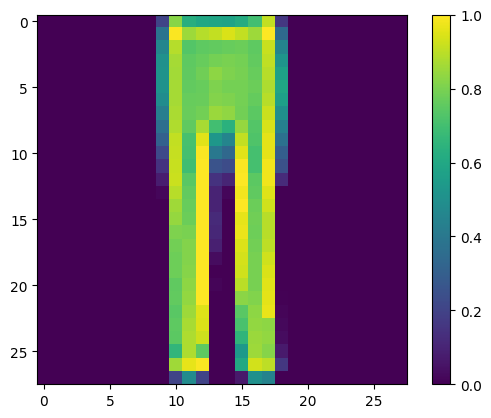

Class: Trouser


In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label])

## 2. 用 TVMScript 手写算子 & MLP 模型

### 2.1 numpy 的模型实现

作为  TVMScript 版本的逻辑参考

In [4]:
# implement using numpy
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

res = numpy_mlp(img.reshape(1, 784), mlp_params["w0"], mlp_params["b0"], mlp_params["w1"], mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("Numpy-MLP Prediction:", class_names[pred_kind[0]])

[[-19.175274   31.845282  -20.67904    -2.5172777 -22.27427   -36.959705
  -58.834312  -25.801823  -23.708206  -37.576492 ]]
[1]
Numpy-MLP Prediction: Trouser


### 2.2 用 TVMScript 实现算子 & MLP 模型

注意，main 函数里是模型，其他函数是算子。另外，用到 2 个新 API:

1. `Relax.call_tir`: 先申请 output 内存，然后传给 TIR 函数。
    - 调用者使用更简单。
    - 以 call_tir 做为 node 画 dataflow 图，更清晰。不再受 output 内存申请 node 的干扰。
2. `with Relax.dataflow()`: 显示声明 dataflow。允许把原图拆成多个 dataflow，dataflow 之间可以插入非 pure function。

In [5]:
# implement using TVMScript
@tvm.script.ir_module
class MyModule: 
    @T.prim_func
    def relu0(X: T.Buffer((1, 128), "float32"), 
              Y: T.Buffer((1, 128), "float32")):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"), 
                W: T.Buffer((128, 784), "float32"), 
                B: T.Buffer((128,), "float32"), 
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer((1, 128), "float32"), 
                W: T.Buffer((10, 128), "float32"), 
                B: T.Buffer((10,), "float32"), 
                Z: T.Buffer((1, 10), "float32")):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"), 
             w0: R.Tensor((128, 784), "float32"), 
             b0: R.Tensor((128,), "float32"), 
             w1: R.Tensor((10, 128), "float32"), 
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            cls = MyModule
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(cls.relu0, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(cls.linear1, (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

Build and Run the Model

In [6]:
ex = relax.build(MyModule, target="llvm")

vm = relax.VirtualMachine(ex, tvm.cpu())

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

nd_res = vm["main"](data_nd, nd_params["w0"], nd_params["b0"], nd_params["w1"], nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Trouser


## 3. 注册 pytorch 算子并使用

注意，用的 API 有变化，新增 `Relax.call_dps_packed`：

1. 前面调用 TVMScript (TIR) 实现的算子，用的 API 是 Relax.call_tir
2. 调用外部注册的算子，传参是 string (func name)，用的 API 是 Relax.call_dps_packed

### 3.1 注册 pytorch 算子

1. 用 `torch.from_dlpack` 从 TVM NDArray 转 torch NDArray. 二者共享内存，是 zero copy 的。
2. DLPack 是不同 framework 之间 zero copy 交换 Tensor/NDArray 的一个标准。https://dmlc.github.io/dlpack/latest/python_spec.html

In [7]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray, 
                 w: tvm.nd.NDArray, 
                 b: tvm.nd.NDArray, 
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray, 
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

### 3.2 混合使用算子

In [8]:
@tvm.script.ir_module
class MyModuleMixture: 
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"), 
                W: T.Buffer((128, 784), "float32"), 
                B: T.Buffer((128,), "float32"), 
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"), 
             w0: R.Tensor((128, 784), "float32"), 
             b0: R.Tensor((128,), "float32"), 
             w1: R.Tensor((10, 128), "float32"), 
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            cls = MyModuleMixture
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

Build and Run the Model

In [9]:
ex = relax.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd, 
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Trouser


## 4. Bind Parameters to IRModule

原文：bind the parameters as constants attached to the IRModule.

通俗的说，把模型权重 bind 到 IRModule 上，这样，后续运行模型时，就不用再传权重了。只需要传 input data。

In [10]:
# bind param, build and run

# nd_params is the weight and bias of the model
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

# only input data is needed as the weight params are already binded
nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Trouser


bind params 后的 IRModule 如下。

重点：`metadata["relax.expr.Constant"][0]` 就是一个存储了权重 constant 的 dict。虽然 display 没显示，但，实际上有真实权重数据的。

In [11]:
MyModuleWithParams.show()